In [99]:
%matplotlib inline

In [1]:
import os

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_io as tfio
from skimage import io
from tensorflow.image import resize
from tensorflow.io import read_file
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Activation,
    Add,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Dropout,
    Input,
    MaxPool2D,
    MaxPooling2D,
    UpSampling2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [101]:
tf.config.experimental.set_memory_growth(tf.config.get_visible_devices()[1], True)

In [102]:
my_file = open("kaggle_3m/README.md", "r")
print(my_file.read())

# LGG Segmentation Dataset

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in `data.csv` file.


All images are provided in `.tif` format with 3 channels per image.
For 101 cases, 3 sequences are available, i.e. pre-contrast, FLAIR, post-contrast (in this order of channels).
For 9 cases, post-contrast sequence is missing and for 6 cases, pre-contrast sequence is missing.
Missing sequences are replaced with FLAIR sequence to make all images 3-channel.
Masks are binary, 1-channel images.
They segment FLAIR abnormality present in the FLAIR sequence (available for all cases).


The dataset is organized into 110 folders na

In [103]:
dir = "kaggle_3m/"
mapped_data = {}
for x in os.listdir(dir):
    if "." in x:
        continue
    for y in os.listdir(os.path.join(dir, x)):
        if y.endswith("_mask.tif"):
            continue
        brain_path = os.path.join(dir, x) + "/" + os.path.join(y)
        brain_mask_path = brain_path.replace(".tif", "_mask.tif")
        mapped_data.update({brain_path: brain_mask_path})

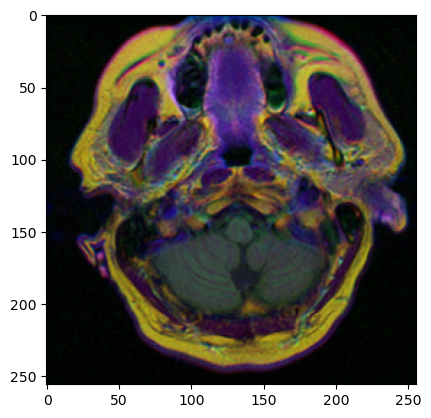

In [104]:
plt.imshow(io.imread(list(mapped_data)[17]))
plt.show()

In [105]:
classes = [0 if np.max(io.imread(x)) == 0 else 1 for x in mapped_data.values()]

In [106]:
brain_data = pd.DataFrame(
    {
        # "pacient_id": id_patient,
        "image_of_pacient": mapped_data.keys(),
        "masks": mapped_data.values(),
        "classes": classes,
    }
)

In [107]:
brain_data = brain_data[brain_data["classes"] == 1]

In [108]:
brain_data.image_of_pacient[2]
print(io.imread(brain_data.image_of_pacient[2]).shape)
plt.show()

(256, 256, 3)


In [109]:
# brain_data

In [154]:
def image_preprocessing(img_file,img_file_mask):
    file = read_file(img_file)
    file_mask = read_file(img_file_mask)
    
    image = tfio.experimental.image.decode_tiff(file)
    image = resize(image, (256, 256))

    image_mask = tfio.experimental.image.decode_tiff(file_mask)
    image_mask = resize(image_mask, (256, 256))
    
    image -= tf.reduce_mean(image)
    image /= tf.math.reduce_std(image)

    image_mask -= tf.reduce_mean(image_mask)
    image_mask /= tf.math.reduce_std(image_mask)

    return image,image_mask

Standardizing an image refers to the process of transforming the pixel values of an image so that it has zero mean and unit variance, i.e., it conforms to a standard normal distribution. This is a commonly used preprocessing step in many image processing and computer vision tasks, as it helps improve the performance of many algorithms by normalizing the input and removing any shift or scaling in the data. Standardizing the images also helps in reducing the impact of lighting conditions, noise and other factors that may affect the performance of the algorithms.The best size to resize the images to depends on the specific problem you are trying to solve and the type of model you are using.

For a U-Net model used for brain tumor segmentation, it's recommended to keep the original image size as much as possible, as the model needs to maintain a high spatial resolution to accurately locate and segment the tumors. Losing resolution due to downsampling may result in the model missing small or irregularly shaped tumors.

However, it's also important to consider the computational requirements of the model, as larger image sizes will increase the memory and computational requirements of the model. In this case, you may need to balance the trade-off between image size and computational efficiency to find the optimal size for your problem.

You can experiment with different image sizes and assess the performance of the model on your validation set to determine the optimal size for your specific problem.

In [111]:
images = list(brain_data.image_of_pacient)

In [112]:
train_masks = brain_data.masks[: int(len(brain_data.masks) * 0.01)]

In [113]:
train = images[: int(len(images) * 0.01)]

In [114]:
train_clasess = classes[: int(len(images) * 0.1)]

In [115]:
val = images[int(len(images) * 0.1) : int(len(images) * 0.11)]

In [116]:
val_clasess = classes[int(len(images) * 0.1) : int(len(images) * 0.11)]

In [117]:
test = images[int(len(images) * 0.1) : int(len(images) * 0.12)]

In [118]:
test_clasess = classes[int(len(images) * 0.1) : int(len(images) * 0.12)]

In [155]:
def make_data_set(files,files_mask):
    return (
        tfio.IODataset.from_tensor_slices((files,files_mask))
        .shuffle(buffer_size=len(files), seed=1234)
        .map(image_preprocessing)
        .batch(batch_size=1)
        .prefetch(tf.data.AUTOTUNE)
        .repeat(len(files))
    )

In [156]:
data = make_data_set(train,train_masks)

A 4-channel image refers to an image format that uses four channels to represent the color information of each pixel. The most common 4-channel image format is the RGBA format, where the "A" stands for alpha channel, which is used to represent the transparency or opacity of each pixel. The RGBA format is commonly used in computer graphics, digital image processing, and video game development. The four channels can be thought of as separate grayscale images, with each channel contributing to the final image's color and transparency. The RGBA format provides more flexibility compared to traditional 3-channel RGB images, as the alpha channel can be used to specify areas of an image that are transparent or semi-transparent.

In [120]:
# for x in train_set.take(1):
#     print(x)

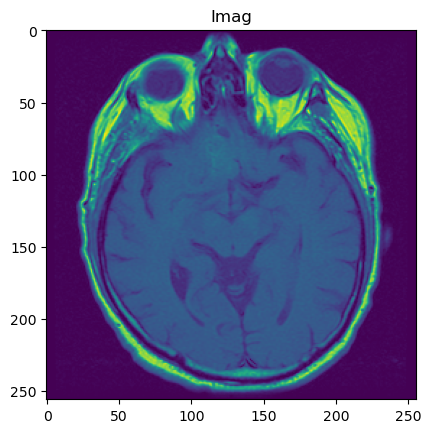

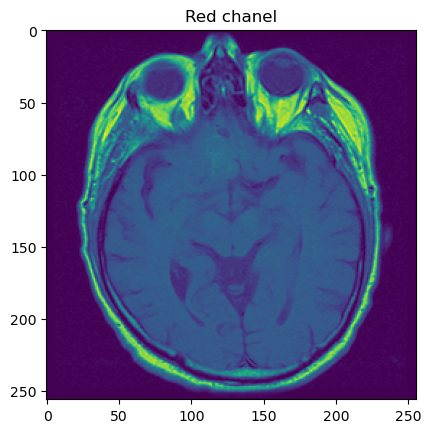

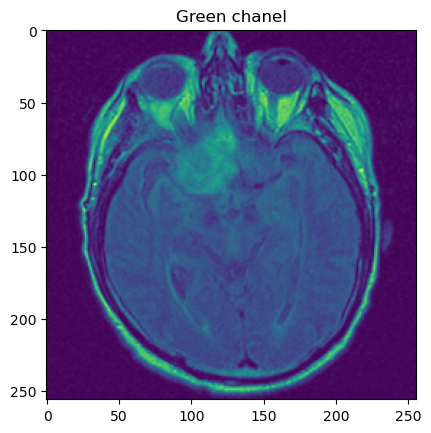

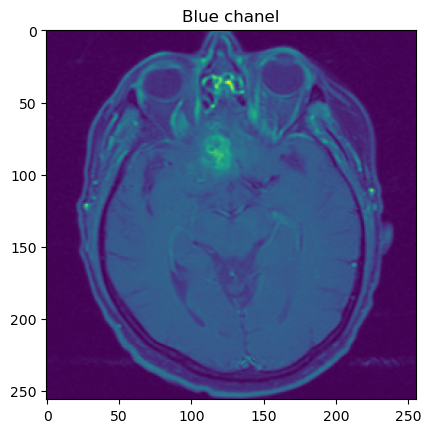

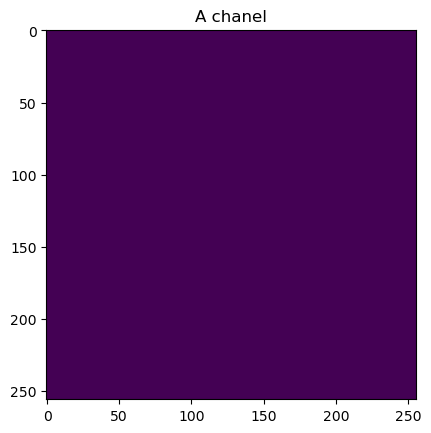

In [121]:
for x in train_mask.take(1):
    # print(x)
    plt.imshow(x[0, :, :, 0])
    plt.title("Imag")
    plt.show()
    plt.imshow(x[0, :, :, 0])
    plt.title("Red chanel")
    plt.show()
    plt.imshow(x[0, :, :, 1])
    plt.title("Green chanel")
    plt.show()
    plt.imshow(x[0, :, :, 2])
    plt.title("Blue chanel")
    plt.show()
    plt.imshow(x[0, :, :, 3])
    plt.title("A chanel")

In [122]:
val_set = make_data_set(val)

In [123]:
test_set = make_data_set(test)

In [234]:
# def check_for_nan(dataset):
#     for data in dataset:
#         if tf.reduce_any(tf.math.is_nan(data)):
#             return "NaN values detected in dataset"
#     return "No NaN values detected in dataset"

# check_for_nan(train_set)

In [148]:
train_mask = make_data_set(train_masks)

In [88]:
train_set = make_data_set(train)

In [96]:
len(train_mask)

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[-0.97558107 -0.9653674  -0.9653674   1.62890556]
   [-0.97558107 -0.9653674  -0.9653674   1.62890556]
   [-0.97558107 -0.95515372 -0.95515372  1.62890556]
   ...
   [-0.97558107 -0.95515372 -0.9653674   1.62890556]
   [-0.97558107 -0.95515372 -0.95515372  1.62890556]
   [-0.97558107 -0.95515372 -0.94494005  1.62890556]]

  [[-0.97558107 -0.95515372 -0.9653674   1.62890556]
   [-0.97558107 -0.95515372 -0.9653674   1.62890556]
   [-0.97558107 -0.94494005 -0.95515372  1.62890556]
   ...
   [-0.97558107 -0.94494005 -0.93472638  1.62890556]
   [-0.97558107 -0.9653674  -0.9245127   1.62890556]
   [-0.97558107 -0.9653674  -0.94494005  1.62890556]]

  [[-0.97558107 -0.94494005 -0.94494005  1.62890556]
   [-0.97558107 -0.93472638 -0.94494005  1.62890556]
   [-0.97558107 -0.93472638 -0.9653674   1.62890556]
   ...
   [-0.97558107 -0.9653674  -0.9653674   1.62890556]
   [-0.97558107 -0.9653674  -0.9653674   1.62890556]
   [-0.97558107 -0.94494005 -0.95515372  1.62890556]]

  ...

 

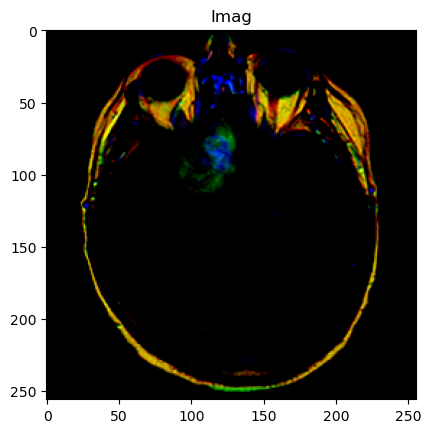

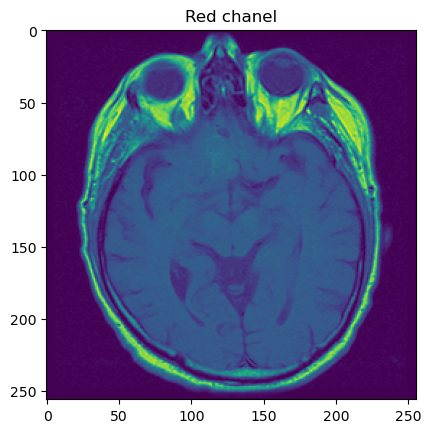

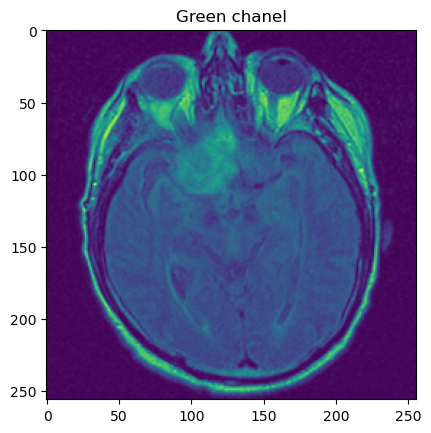

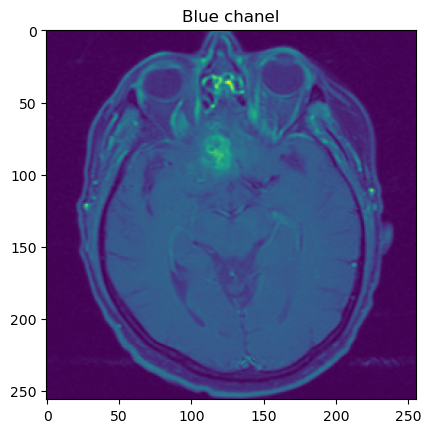

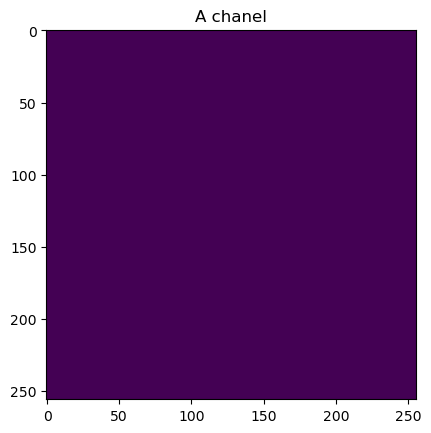

In [95]:
for imgs in train_mask.take(1):
    print(imgs)
    plt.imshow(imgs[0, :, :, :])
    plt.title("Imag")
    plt.show()
    plt.imshow(imgs[0, :, :, 0])
    plt.title("Red chanel")
    plt.show()
    plt.imshow(imgs[0, :, :, 1])
    plt.title("Green chanel")
    plt.show()
    plt.imshow(imgs[0, :, :, 2])
    plt.title("Blue chanel")
    plt.show()
    plt.imshow(imgs[0, :, :, 3])
    plt.title("A chanel")
    plt.show()

A CMYK image has four channels: cyan, magenta, yellow, and key (black). CMYK is the standard for print, where subtractive coloring is used. A 32-bit CMYK image (the industry standard as of 2005) is made of four 8-bit channels, one for cyan, one for magenta, one for yellow, and one for key color (typically is black).

In [ ]:
# for x in train_set.take(1):
#     print(x)

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [141]:
# lets create model now
def resblock(X, f):
    """
    function for creating res block
    """
    X_copy = X  # copy of input

    # main path
    X = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    X = Conv2D(f, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)

    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together
    X = Add(dtype='float32')([X, X_copy])
    X = Activation("relu")(X)

    return X


def upsample_concat(x, skip):
    """
    funtion for upsampling image
    """
    X = UpSampling2D((2, 2))(x)
    merge = Concatenate( dtype='float32')([X, skip])

    return merge

In [142]:
input_shape = (256, 256, 4)
X_input = Input(input_shape)  # iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(
    16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
)(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(
    16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
)(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2, 2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2, 2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2, 2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2, 2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(
    4, (1, 1), kernel_initializer="he_normal", padding="same", activation="sigmoid"
)(up_4)
u_net = Model(X_input, out)
# u_net.summary()

In [129]:
def dice_coef(y_true, y_pred, epsilon=1):
    dice_numerator = 2.0 * K.sum(y_true * y_pred) + epsilon
    dice_denominator = K.sum(y_true * y_true) + K.sum(y_pred * y_pred) + epsilon
    return K.mean((dice_numerator) / (dice_denominator))


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)



In [146]:
train_mask

<RepeatDataset shapes: (None, 256, 256, None), types: tf.float64>

In [143]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
u_net.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])

In [163]:
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def compute_gradient(model, pred, actual):
    """compute gradients with given noise and input"""
    with tf.GradientTape() as tape:
        loss = compute_loss(pred, actual)
    grads = tape.gradient(loss, model.variables)
    return grads, loss

def apply_gradients(optimizer, grads, model_vars):
    optimizer.apply_gradients(zip(grads, model_vars))

model = u_net

epochs = 2# 10
batch_size = 25
itr = y.shape[0] // batch_size
for epoch in range(epochs):
    for data in data:
        preds = model(data)
        grads, loss = compute_gradient(model, preds, data)
        print(grads)
        apply_gradients(optimizer, grads, model.variables)

NameError: name 'mask' is not defined

In [136]:
def dice_coef(y_true, y_pred, epsilon=1):
    dice_numerator = 2.0 * K.sum(y_true * y_pred) + epsilon
    dice_denominator = K.sum(y_true * y_true) + K.sum(y_pred * y_pred) + epsilon
    return K.mean((dice_numerator) / (dice_denominator))


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


# Define the optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
num_of_epoch = 4
# Train the model
for epoch in range(num_of_epoch):
    for x, y in zip(train_set, train_mask):
        # Use GradientTape to record the forward pass
        with tf.GradientTape() as tape:
            y_pred = u_net(x)
            loss = dice_coef_loss(y, y_pred)

        # Calculate the gradients with respect to the variables
        gradients = tape.gradient(loss, u_net.trainable_variables)
        # clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.0)

        # Apply the gradients to the optimizer
        optimizer.apply_gradients(zip(gradients, u_net.trainable_variables))
    loss, accuracy = u_net.evaluate(y, y_pred)
    print(f"Epoch: {epoch}, Loss: {loss}, acc: {accuracy}")
    if epoch + 1 == num_of_epoch:
        u_net.save(f"u_net_model")

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Mul]

In [137]:
def compute_loss(pred, actual):
    return tf.reduce_mean(tf.square(tf.subtract(pred, actual)))

def compute_gradient(model, pred, actual):
    """compute gradients with given noise and input"""
    with tf.GradientTape() as tape:
        loss = compute_loss(pred, actual)
    grads = tape.gradient(loss, model.variables)
    return grads, loss

def apply_gradients(optimizer, grads, model_vars):
    optimizer.apply_gradients(zip(grads, model_vars))

model = make_model()
optimizer = tf.train.AdamOptimizer(1e-4)

x = np.linspace(0,1,1000)
y = x+np.random.normal(0,0.3,1000)
y = y.astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices((y.reshape(-1,1)))

epochs = 2# 10
batch_size = 25
itr = y.shape[0] // batch_size
for epoch in range(epochs):
    for data in tf.contrib.eager.Iterator(train_dataset.batch(25)):
        preds = model(data)
        grads, loss = compute_gradient(model, preds, data)
        print(grads)
        apply_gradients(optimizer, grads, model.variables)

NameError: name 'make_model' is not defined

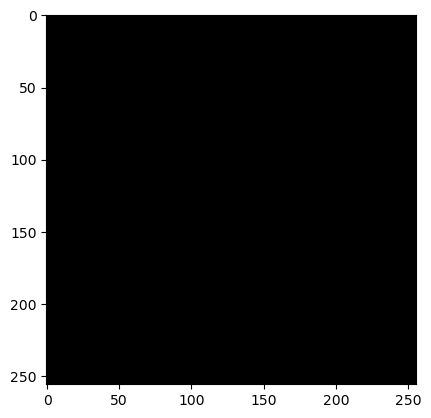

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


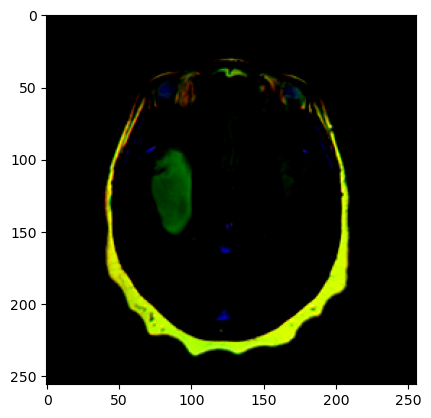

In [243]:
for x in train_set.take(1):
    predicted = u_net.predict(x)
    # print(predicted)
    plt.imshow(predicted[0, :, :, :])
    plt.show()
    plt.imshow(x[0, :, :, :])

In [ ]:
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (
        true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth
    )


def focal_tversky(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1 - pt_1), gamma)


def tversky_loss(y_true, y_pred):
    return -K.log(tversky(y_true, y_pred))

In [ ]:
u_net.trainable_variables

In [ ]:
len(train_set)

In [ ]:
weights = []
for layer in u_net.layers:
    layer_weights = layer.get_weights()
    weights.append(layer_weights)

In [ ]:
# weights

In [ ]:
u_net.predict

In [ ]:
# experimental.summary()

In [ ]:
# u_net.summary()

In [ ]:
# plot_model(u_net, to_file='model.png', show_shapes=True,dpi=96)

In [ ]:
# plot_model(experimental, show_shapes=True,dpi=96)

In [ ]:
smooth = 100


def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return (2 * And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


def jac_distance(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)

    return -iou(y_true, y_pred)

In [ ]:
u_net.compile(
    optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef]
)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)

In [ ]:
def accuracy(labels, logits):
    predictions = tf.argmax(logits, axis=1)
    labels = tf.argmax(labels, axis=1)
    acc = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    return acc

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

with tf.GradientTape() as tape:
    grads = tape.gradient(loss_fn, u_net.trainable_variables)
    # optimizer.apply_gradients(zip(grads, u_net.trainable_variables))

In [ ]:
for x in train_set.take(1):
    # print(x.shape)
    # plt.imshow(imgs[0,:, :, 0])
    plt.imshow(u_net.predict(x))

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)
u_net.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

In [ ]:
earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(
    filepath="u_net_weights.hdf5", verbose=1, save_best_only=True
)

In [ ]:
a = u_net.fit(train_set, train_step=3, epochs=2, validation_data=val_set)

In [ ]:
u_net_model.model.save("saved_model_u_net")

In [ ]:
for x in test_set.take(1):
    plt.imshow(u_net_model.model.predict(x))

In [ ]:
u_net_pd = pd.Series(
    {
        "loss": u_net_model.history["loss"],
        "val_loss": u_net_model.history["val_loss"],
        "accuracy": u_net_model.history["accuracy"],
        "val_accuracy": u_net_model.history["val_accuracy"],
    }
)

In [ ]:
u_net_pd.to_pickle("u_net_history.pkl")

In [ ]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(u_net_pd.loss);
# plt.plot(u_net_pd.val_loss);
# plt.title("Classification Model LOSS");
# plt.ylabel("loss");
# plt.xlabel("Epochs");
# plt.legend(['train', 'val']);

# plt.subplot(1,2,2)
# plt.plot(u_net_pd.accuracy);
# plt.plot(u_net_pd.val_accuracy);
# plt.title("Classification Model Acc");
# plt.ylabel("Accuracy");
# plt.xlabel("Epochs");
# plt.legend(['train', 'val']);

In [ ]:
# !mkdir -p saved_model_u_net

In [ ]:
# model_stat=pd.Series({"loss":u_net.history['loss'],
#                       'val_loss':u_net.history['val_loss'],
#                       'accuracy':u_net.history['accuracy'],
#                       'val_accuracy':u_net.history['val_accuracy']
#                      })

In [ ]:
model_stat.to_pickle("my_data_resnet_152.pkl")

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for x in train_set:
        # print(np.expand_dims(x[0], axis=0))
        # break
        with tf.GradientTape() as tape:
            # Forward pass
            # logits = u_net(np.expand_dims(, axis=0), training=True)
            print(u_net.trainable_variables)
#             loss_value= tf.keras.losses.binary_crossentropy(x[1], u_net(x[0]))

#         # Compute gradients
#         grads = tape.gradient(loss_value, u_net.trainable_variables)

#         # Update model weights
#         u_net.optimizer.apply_gradients(zip(grads, u_net.trainable_variables))

In [ ]:
def model(x):
    return w * x + b


# Define the loss function
def loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))


# Train the model
learning_rate = 0.01
num_epochs = 100
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        y_pred = model(u_net)
        current_loss = loss(y_pred, y)
    gradients = tape.gradient(current_loss, [w, b])
    w.assign_sub(learning_rate * gradients[0])
    b.assign_sub(learning_rate * gradients[1])
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}: loss={current_loss.numpy()}")

print(f"Final model parameters: w={w.numpy()}, b={b.numpy()}")

In [ ]:
train_x = tf.random.normal(shape=(100, 256, 256, 4), dtype=tf.float32)

In [ ]:
# Create a dataset from a tensor
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.batch(4)
# Create a simple model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(16, activation="relu", input_shape=(1,)),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model on the dataset
model.fit(dataset, epochs=10)